In [1]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import cv2
from tqdm import tqdm
import datetime
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPooling2D,Dropout,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
%matplotlib inline

from IPython.display import HTML
from base64 import b64encode

In [ ]:
train_data_dir = "/content/drive/MyDrive/Colab Notebooks/dataset/kitti_dataset/training/image_2/"
train_gt_dir = "/content/drive/MyDrive/Colab Notebooks/dataset/kitti_dataset/training/gt_image_2/"

test_data_dir = "/content/drive/MyDrive/Colab Notebooks/dataset/kitti_dataset/testing/"

In [2]:
# Number of training examples
TRAINSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.8)
print(f"Number of Training Examples: {TRAINSET_SIZE}")

VALIDSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.1)
print(f"Number of Validation Examples: {VALIDSET_SIZE}")

TESTSET_SIZE = int(len(os.listdir(train_data_dir)) - TRAINSET_SIZE - VALIDSET_SIZE)
print(f"Number of Testing Examples: {TESTSET_SIZE}")

NameError: ignored

In [ ]:
# Initialize Constants
IMG_SIZE = 128
N_CHANNELS = 3
N_CLASSES = 1
SEED = 123

In [ ]:
# Function to load image and return a dictionary
def parse_image(img_path: str) -> dict:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # Three types of img paths: um, umm, uu
    # gt image paths: um_road, umm_road, uu_road
    mask_path = tf.strings.regex_replace(img_path, "image_2", "gt_image_2")
    mask_path = tf.strings.regex_replace(mask_path, "um_", "um_road_")
    mask_path = tf.strings.regex_replace(mask_path, "umm_", "umm_road_")
    mask_path = tf.strings.regex_replace(mask_path, "uu_", "uu_road_")
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    
    non_road_label = np.array([255, 0, 0])
    road_label = np.array([255, 0, 255])
    other_road_label = np.array([0, 0, 0])
    
    # Convert to mask to binary mask
    mask = tf.experimental.numpy.all(mask == road_label, axis = 2)
    mask = tf.cast(mask, tf.uint8)
    mask = tf.expand_dims(mask, axis=-1)

    return {'image': image, 'segmentation_mask': mask}

In [ ]:
# Generate dataset variables
all_dataset = tf.data.Dataset.list_files(train_data_dir + "*.png", seed=SEED)
all_dataset = all_dataset.map(parse_image)

train_dataset = all_dataset.take(TRAINSET_SIZE + VALIDSET_SIZE)
val_dataset = train_dataset.skip(TRAINSET_SIZE)
train_dataset = train_dataset.take(TRAINSET_SIZE)
test_dataset = all_dataset.skip(TRAINSET_SIZE + VALIDSET_SIZE)

In [ ]:
# Tensorflow function to rescale images to [0, 1]
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

# Tensorflow function to apply preprocessing transformations
@tf.function
def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

# Tensorflow function to preprocess validation images
@tf.function
def load_image_test(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

dataset = {"train": train_dataset, "val": val_dataset, "test": test_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=tf.data.AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=tf.data.AUTOTUNE)

#-- Testing Dataset --#
dataset['test'] = dataset['test'].map(load_image_test)
dataset['test'] = dataset['test'].batch(BATCH_SIZE)
dataset['test'] = dataset['test'].prefetch(buffer_size=tf.data.AUTOTUNE)

print(dataset['train'])
print(dataset['val'])
print(dataset['test'])

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


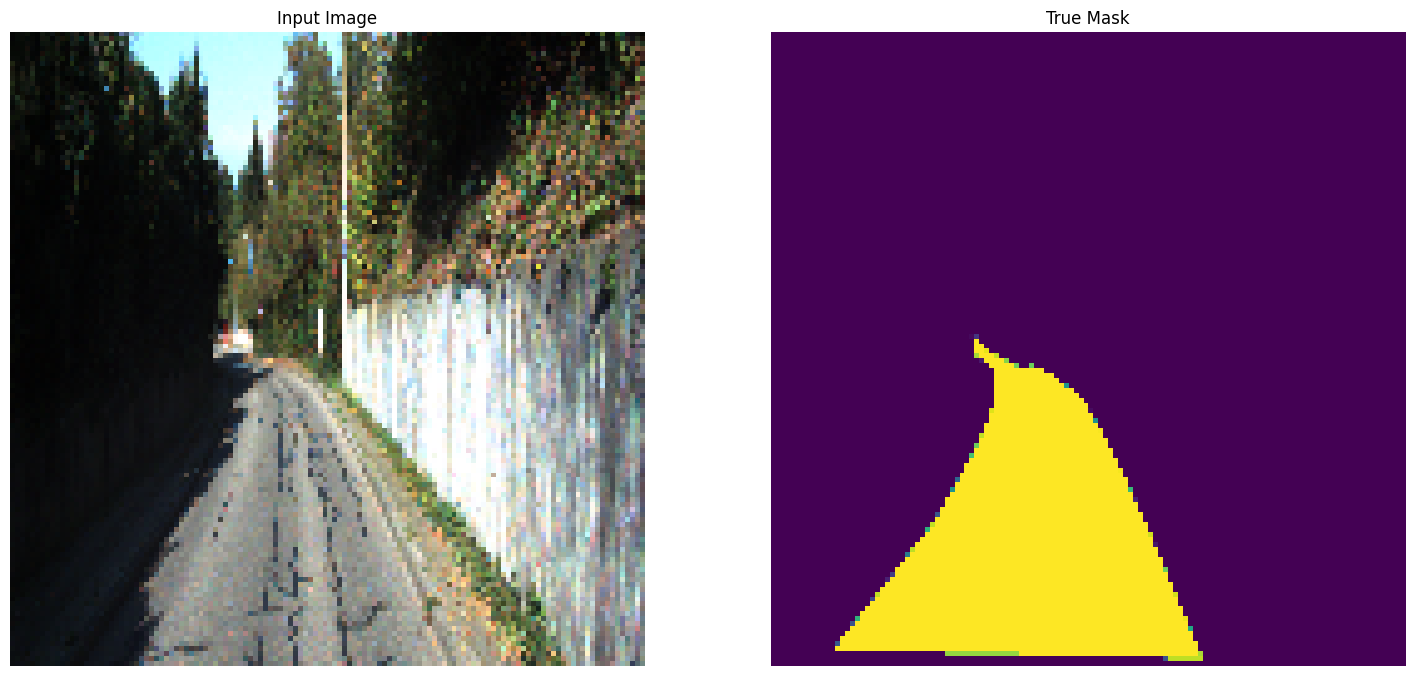

In [ ]:
# Function to view the images from the directory
def display_sample(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.show()
    
for image, mask in dataset["train"].take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])

In [ ]:
#Build the model
inputs = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, N_CHANNELS))

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
m_iou = tf.keras.metrics.MeanIoU(2)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[m_iou])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 128, 128, 16  448         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_27 (Dropout)           (None, 128, 128, 16  0           ['conv2d_57[0][0]']              
                                )                                                           

1/1 [==============================] - 10s 10s/step


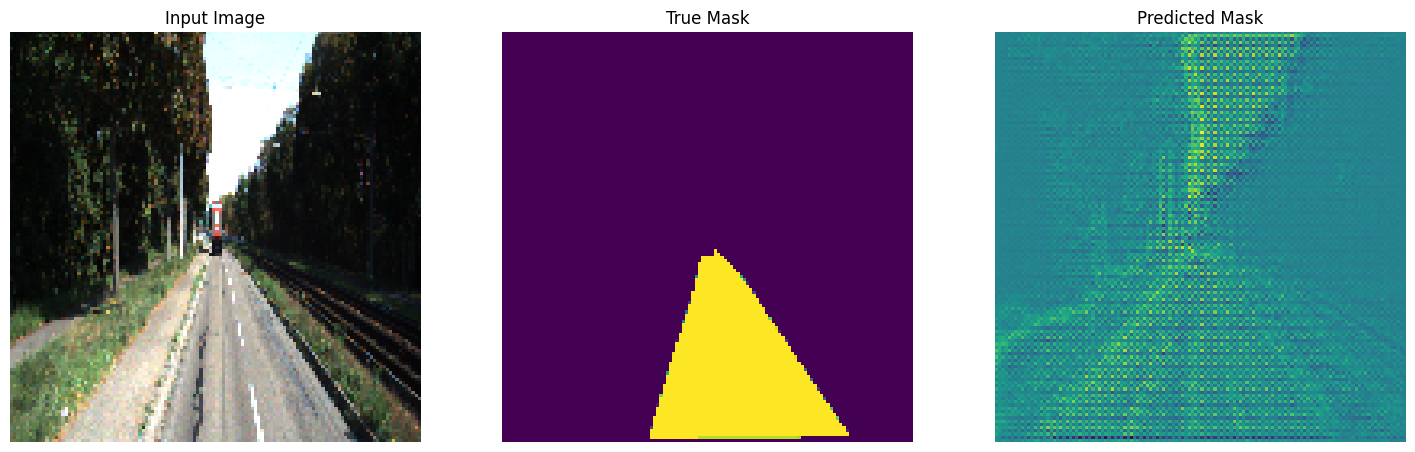

In [ ]:
# Function to create a mask out of network prediction
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    # Round to closest
    pred_mask = tf.math.round(pred_mask)
    
    # [IMG_SIZE, IMG_SIZE] -> [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

# Function to show predictions
def show_predictions(dataset=None, num=1):
    if dataset:
        # Predict and show image from input dataset
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], true_mask, create_mask(pred_mask)])
    else:
        # Predict and show the sample image
        inference = model.predict(sample_image)
        display_sample([sample_image[0], sample_mask[0],
                        inference[0]])
        
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

show_predictions()

In [ ]:
# Callbacks and Logs
class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

callbacks = [
    DisplayCallback(),
    callbacks.EarlyStopping(patience = 10, verbose = 1),
    callbacks.ModelCheckpoint('best_model.h5', verbose = 1, save_best_only = True)
]

# Set Variables
EPOCHS = 20
STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALIDSET_SIZE // BATCH_SIZE

1/1 [==============================] - 0s 36ms/step


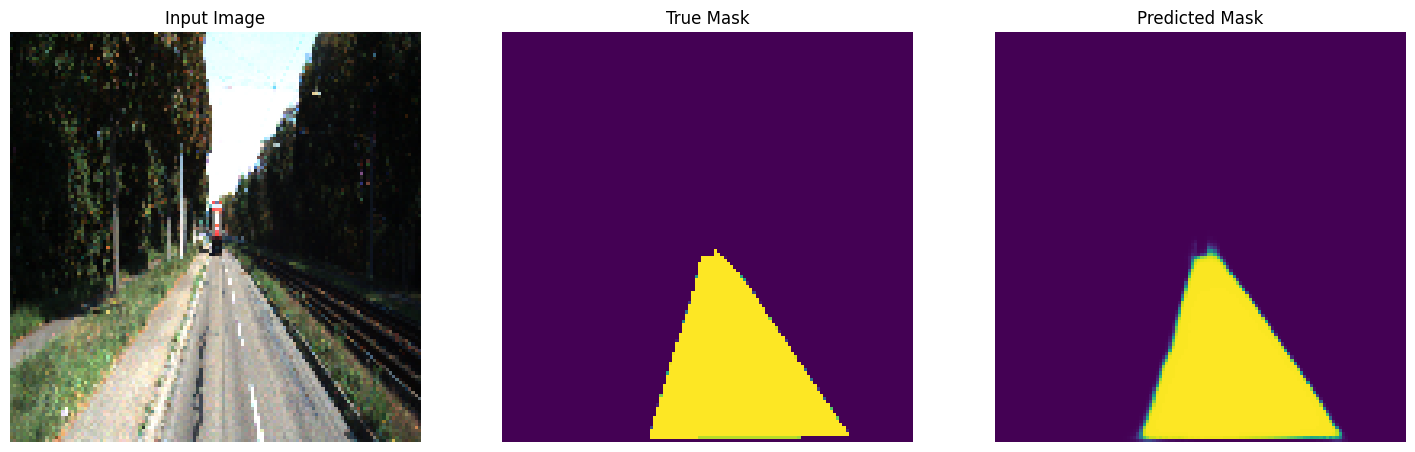


Sample Prediction after epoch 20



7/7 [==============================] - 5s 794ms/step - loss: 0.0145 - mean_io_u: 0.7018


In [ ]:
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data = dataset["val"],
                          validation_steps=VALIDATION_STEPS,
                          callbacks = callbacks)

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/model/unet1.h5")

In [ ]:
# Function to calculate mask over image
def weighted_img(img, initial_img, α=1., β=0.5, γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

# Function to process an individual image and it's mask
def process_image_mask(image, mask):
    # Round to closest
    mask = tf.math.round(mask)
    
    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image))
    mask = np.asarray(mask, np.float32)
    
    # Convert to image image
    image = np.asarray(image, np.float32)
    
    # Get the final image
    final_image = weighted_img(mask, image)

    return final_image

In [ ]:
# Function to save predictions
def save_predictions(dataset):
    # Predict and save image the from input dataset
    index = 0
    for batch_image, batch_mask in dataset:
        for image, mask in zip(batch_image, batch_mask):
            print(f"Processing image : {index}")
            pred_mask = model.predict(tf.expand_dims(image, axis = 0))
            save_sample([image, process_image_mask(image, pred_mask[0])], index)
            index += 1

# Function to save the images as a plot
def save_sample(display_list, index):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.savefig(f"outputs/{index}.png")
    plt.show()

In [ ]:
# Function to process an individual image
def process_image(image):
    # Preprocess image
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    # Get the binary mask
    pred_mask = model.predict(np.expand_dims(image, axis = 0))
    mask = np.round_(pred_mask[0])
    
    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image)) * 255
    mask = np.asarray(mask, np.uint8)
    
    # Get the final image
    final_image = weighted_img(mask, image)
    final_image = cv2.resize(final_image, (1280, 720))

    return final_image

In [ ]:
# Creating a VideoCapture object to read the video
project_video = "project_video.mp4"
original_video = cv2.VideoCapture(test_data_dir + project_video)
frame_width = int(original_video.get(3))
frame_height = int(original_video.get(4))
 
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
fps = 60
output = cv2.VideoWriter("/content/drive/MyDrive/Colab Notebooks/videos/" + project_video, fourcc, fps, (frame_width,frame_height))

# Process Video
while(original_video.isOpened()):
    ret, frame = original_video.read()

    if ret == True:
        # Write the frame into the file 'output.avi'
        output.write(process_image(frame))

    else:
        break

# When everything done, release the video capture and video write objects
original_video.release()
output.release()

1/1 [==============================] - 0s 18ms/step


In [ ]:
# Creating a VideoCapture object to read the video
project_video = "harder_challenge_video.mp4"
original_video = cv2.VideoCapture(test_data_dir + project_video)
frame_width = int(original_video.get(3))
frame_height = int(original_video.get(4))
 
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
fps = 60
output = cv2.VideoWriter("/content/drive/MyDrive/Colab Notebooks/videos/" + project_video, fourcc, fps, (frame_width,frame_height))

# Process Video
while(original_video.isOpened()):
    ret, frame = original_video.read()

    if ret == True:
        # Write the frame into the file 'output.avi'
        output.write(process_image(frame))

    else:
        break

# When everything done, release the video capture and video write objects
original_video.release()
output.release()

1/1 [==============================] - 0s 23ms/step
